### Практическая работа №3: Кластерный анализ
Выполнил студент гр. 0373 Власюк Мирослав Вариант №3

## Цель работы
Освоение основных понятий и некоторых методов кластерного анализа,
в частности, метода k-means и метода поиска сгущений.

## Основные теоретические положения

Нормализация - это этап предварительной обработки любого типа постановки задач

Нормализация по методу минимакс

$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$


"Грубая" верхняя оценка количества кластеров $\widetilde{k}$  
$\tilde{k} = \lfloor \sqrt{\frac{n}{2}} \rfloor$  

Метрика — функция, определяющая расстояния в метрическом пространстве.

Некоторые виды метрик:


Евклидово расстояние: $d_{ij}=\sqrt{\sum_{k=1}^{m}{(x_{ik}-x_{jk})}^2}$  


Расстояние городских кварталов (Манхэттенское расстояние): $d(x,y)=\sum_{i=1}^{n}{|x_{i}-y_{i}|}$  

Метод кластерного анализа относится к группе методов "обучение без учителя". Это значит, что никто не знает правильного ответа на интересующий нас вопрос и нет никакой обратной связи.

Центроиды - геометрические центры предполагаемых кластеров с координатами 

**Алгоритм метода k-средних:**
1. Сами решаем на сколько кластеров будем делить.
2. Случайно выбираем начальные позиции центроидов кластера.
3. Для каждого наблюдения определяем, к какому центроиду он ближе всего c помощью метрики.
4. Обновим позиции центроидов (среднее по каждой переменной для группы).
5. Если принадлежности некоторых точек изменились, то возвращаемся в пункт 4, иначе алгоритм сошелся.


Алгоритм k-medians - это вариация k-means метода кластеризации, где для определения центра кластера вместо среднего вычисляется медиана (по каждому из измерений)


Коэффициент силуэта или показатель силуэта - это показатель, используемый для оценки качества кластеров, созданных алгоритмом.

$s_{i}=\frac{b_i-a_i}{max(a_i,b_i)}$


$a_{i}=\frac{1}{\|C_{I}|-1}\sum_{j \in C_{I} i \neq j}{d(i, j)} $  


$b_i=min_{J \neq I}\frac{1}{|C_J|}\sum_{j \in C_J}{d(i, j)}$  

FOREL (Формальный Элемент) — алгоритм кластеризации, основанный на идее объединения в один кластер объектов в областях их наибольшего сгущения  

**Алгоритм метода Forel:** 
1. Аналитически выбираем центроиду.
2. Помечаем объекты выборки, находящиеся на расстоянии меньшем, чем R от текущей центроиды.
3. Вычисляем центр тяжести кластера, помечаем этот центр как новую текущую центроиду.
4. Повторяем шаги 2-3, пока новый текущий центр не совпадет с прежней центроидой.
5. Помечаем объекты внутри сферы радиуса R вокруг текущего центра как кластеризованные и выкидываем их из выборки.
6. Повторяем шаги 1-5, пока не будет кластеризована вся выборка.



## Постановка задачи
Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №2). Выполнить разбиение исходного множества объектов на конечное число подмножеств
(кластеров) с использованием метода k-means и метода поиска сгущений. Полученные результаты содержательно проинтерпретировать

## Выполнение работы


In [1]:
import csv
import pandas as pd
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
import scipy.stats
import statistics
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
class my_Clustering:
    
    def train(self, X, k, eps, checker):
        self.data = copy.deepcopy(X)
        #self.centroids = M
        if checker == 'kmeans++':
            self.kmeans_pp(X, k)
        else:
            self.centroids = X[np.random.choice(len(X), k)]

        has_converged = False
        
        while not has_converged:
            self.clusters_assignment = self.assign_clusters(X) # присвоение меток 
            new_centroids = self.move_centroids(X, k, self.clusters_assignment, checker) # передвижение  центроида
            has_converged = np.linalg.norm(new_centroids - self.centroids) < eps
            self.centroids = new_centroids
            
        return self.clusters_assignment, self.centroids
            
    def evaluate(self, X, checker):  # среднее внутрикластерное состояние
        cluster_assignment = self.assign_clusters(X)
        numerator = 0
        denominator = 0
        for k in range(len(self.centroids)):
            cluster = X[cluster_assignment == k]
            if len(cluster) < 2:
                continue
            if checker == 'kmeans' or 'kmeans++':
                numerator += evklid_dist(cluster)
                denominator += (len(cluster) * (len(cluster) - 1)) / 2
            if checker == 'kmedians':
                numerator += manhattan_dist(cluster)
                denominator += (len(cluster) * (len(cluster) - 1)) / 2
            
        return numerator / denominator
    
    def assign_clusters(self, X): # каждый объект из X ставится  индекс кластера к которому она ближе всего
        return np.array([
            np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X
        ])
    
    def move_centroids(self, X, k, clusters_assignment, checker): # для каждого кластера меняет значения и берем среднее кластера
        
        new_centroids = np.zeros_like(self.centroids)
        
        if checker == 'kmeans' or 'kmeans++':
            for i in range(k):
                cluster = X[clusters_assignment == i]
  #              print(f'i:{i}\nclus{cluster}\nmd{np.mean(cluster, axis=0)}')
                
                if not len(cluster):
                    continue
                new_centroids[i] = np.mean(cluster, axis=0)

            return new_centroids
        if checker == 'kmedians':
            for i in range(k):
                cluster = X[clusters_assignment == i]
                #print(f'i:{i}\nclus{cluster}\nmd{np.median(cluster)}')
                
                if not len(cluster):
                    continue
                new_centroids[i] = np.median(cluster, axis=0)
            return new_centroids
        
    def evklid_dist(cluster):
        raznost = np.sqrt((centroid - clust)**2)
        total = np.sum(raznost)
        return total
    
    def manhattan_dist(self, cluster):
        diff = abs(centroid - cluster)
        return sum(diff)
    
    

    
    def plot_clusters(self):
        df = pd.DataFrame(self.data, columns=(['x', 'y']))
        df['clus'] = copy.deepcopy(self.clusters_assignment) + 1
        df["clus"] = df["clus"].astype(str)

        kmeans_centroid = copy.deepcopy(self.centroids)
        df2 = pd.DataFrame(kmeans_centroid, columns=(['x','y']))

        fig = px.scatter(df, x="x", y="y", color='clus', title='Scatter plot')
        #centroid_point = go.Scatter(df2, x="x", y="y", mode="markers",  name='centroid')
        centroid_point = go.Scatter(x=df2['x'], y=df2['y'], mode='markers',marker=dict(size=8, symbol="diamond", line=dict(width=2, color="DarkSlateGrey")),
                                    name='centroid')
        fig.add_trace(centroid_point)
        fig.update_layout(title="Scatter plot",
                          margin=dict(l=0, r=0,b=0, t=30))
        fig.show("png")
        #fig.show()
        
    def kmeans_pp(self, X, k):
        self.centroids = [X[np.random.randint(0, len(X) - 1)]]
        for i in range(1, k):
            dist = np.array([np.linalg.norm(self.centroids - x, axis=1).min() for x in X])
            dist /= dist.sum()
            random_index = np.random.choice(range(len(X)), 1, p=dist)[0]
            self.centroids.append(X[random_index])
            
def method_siluet(array, eps, checker):
    quant_clus = list (range(2,8))
    result = []
    import sklearn.metrics
    df = pd.DataFrame(array)
    preds = 0
    centers = 0
    for i in quant_clus:
        kmeans_clus, kmeans_centr = kmeans.train(array, i, eps, checker)
        preds = kmeans_clus
        centers = kmeans_centr
        score = sklearn.metrics.silhouette_score(df, preds)
        
        result.append(score)
        
        

    print(result)

    df = pd.DataFrame(array, columns=(['x', 'y']))
    df['clus'] = copy.deepcopy(kmeans_clus) + 1
    df["clus"] = df["clus"].astype(str)

    kmeans_centroid = copy.deepcopy(kmeans_centr)
    df2 = pd.DataFrame(kmeans_centroid, columns=(['x','y']))

    fig = px.scatter(df, x="x", y="y", color='clus', title='Scatter plot')
    fig2 = px.scatter(x=quant_clus, y=result)
    centroid_point = go.Scatter(x=df2['x'], y=df2['y'], mode='markers',marker=dict(size=8, symbol="diamond", line=dict(width=2, color="DarkSlateGrey")),
                                name='centroid')
    fig.add_trace(centroid_point)
    fig.update_layout(title="Scatter plot",
                      margin=dict(l=0, r=0,b=0, t=30))
    #fig.show("png")
    fig2.show("png")
    

def sum_values(arr):
    count = 0
    for i in arr:
            count += i
    return count

### Пункт 1 Нормализовать множество точек из предыдущей работы, отобразить полученное множество.

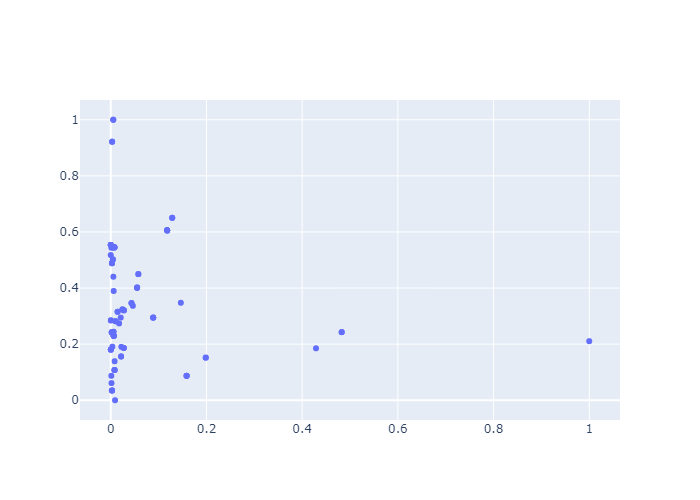

In [3]:
df = pd.read_csv("./vMiro.csv", header=None)
array_x = df[0].to_numpy()
array_y = df[1].to_numpy()
len_vibor = len(array_x)
len_vibor
norm_array_x = (array_x - min(array_x) ) / (max(array_x) - min(array_x))
norm_array_y = (array_y -   min(array_y)) / (max(array_y) - min(array_y))
fig = go.Figure()
fig.add_trace(go.Scatter(x=norm_array_x, y=norm_array_y, mode='markers'))
#fig.add_trace(go.Scatter(x=array_x, y=lin_alg_point))
fig.show("png")


### Пункт 2 Определить «грубую» верхнюю оценку количества кластеров  $\tilde k$.

In [4]:
quantity_clus = int((len_vibor/2)**0.5)
print(f'Количество кластеров = {quantity_clus}')

Количество кластеров = 6


### Пункт 3 Реализовать алгоритм k-means. Отобразить полученные кластеры,каждый кластер выделить разным цветом или маркером, отметить центроиды

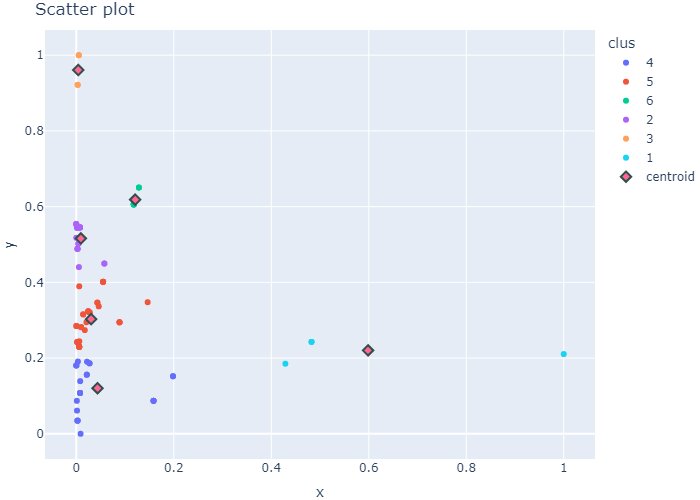

In [5]:
kmeans = my_Clustering()
eps = 0.0001
arr_2d = np.concatenate([norm_array_x[:,None],norm_array_y[:,None]], axis=1)

kmeans_clus, kmeans_centr = kmeans.train(arr_2d, quantity_clus, eps, 'kmeans')
kmeans.plot_clusters()


### Пункт 4 Реализовать алгоритмы k-medians. Отобразить полученные кластеры, каждый кластер выделить разным цветом или маркером, отметить центроиды.

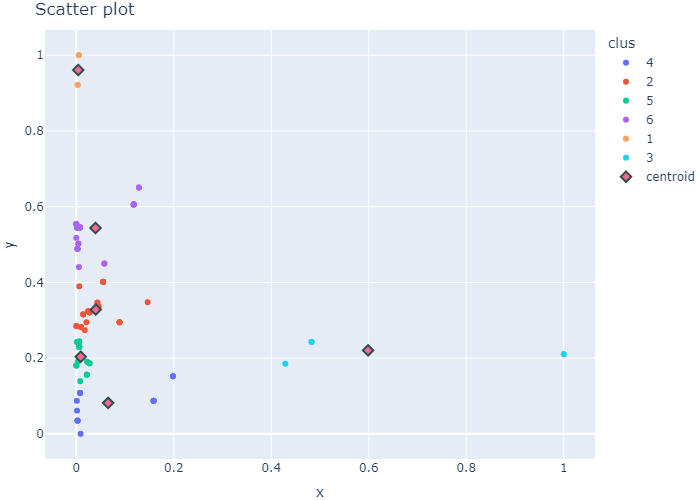

In [6]:
kmedians = my_Clustering()
kmedians_clus, kmedians_centr = kmedians.train(arr_2d, quantity_clus, eps, 'kmedians')
kmedians.plot_clusters()

### Пункт 5 Для каждого метода заполнить следующую таблицу где значения 𝑘 изменяются от 1 до $\tilde k$

In [7]:
def create_table(clus, centr):
    df = pd.DataFrame(clus + 1, columns=(['1']))
    df = df.groupby(df.columns.tolist(),as_index=False).size()
    strAr = []
    for i in centr: 
        strAr.append(str(i))
    df.insert(1, '2', strAr)

    sum_df = pd.DataFrame({'1' : [' '],
                           '2'   : [' '],
                           'size'  : [sum_values(df['size'])]})
    sum_df.index=['∑']

    df = round(pd.concat([df, sum_df], axis=0, ignore_index=False), 2) # объединение дфов

    df = df.rename(columns={"1": "Номер кластера", "2": "Центроид кластера", "size": "Объем кластера"})

    print(df)
    

In [8]:
create_table(kmeans_clus, kmeans_centr)


  Номер кластера        Центроид кластера  Объем кластера
0              1  [0.59857224 0.22030602]               4
1              2  [0.00949041 0.51596964]              19
2              3  [0.00409403 0.96084025]               4
3              4  [0.0436536  0.12033195]              24
4              5  [0.03051682 0.30292028]              33
5              6  [0.12096344 0.61855365]               7
∑                                                      91


In [9]:
create_table(kmedians_clus, kmedians_centr)

  Номер кластера        Центроид кластера  Объем кластера
0              1  [0.00409403 0.96084025]               4
1              2  [0.04016252 0.32818983]              24
2              3  [0.59857224 0.22030602]               4
3              4  [0.06541994 0.08154268]              14
4              5  [0.00920853 0.20348329]              19
5              6  [0.03950238 0.54358841]              26
∑                                                      91


### Пункт 6 С помощью метода силуэтов выявить для каждого метода оптимальное количество кластеров.


Метод силуэта для kmeans

[0.5226516621955256, 0.45270832117591503, 0.5907208280894103, 0.5353472283488945, 0.45392843318446374, 0.49508509458462996]


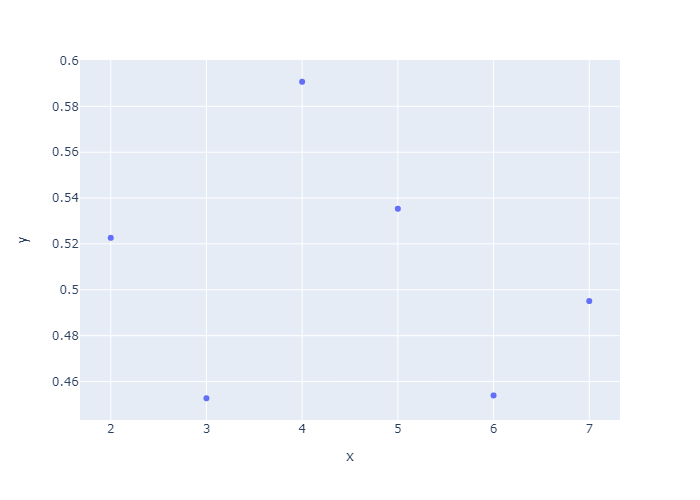

In [24]:
method_siluet(arr_2d, eps, 'kmeans')

Метод силуэта для kmedians

[0.5164113530283198, 0.45270832117591503, 0.5907208280894103, 0.4651285703983067, 0.465166401722046, 0.45276744409293374]


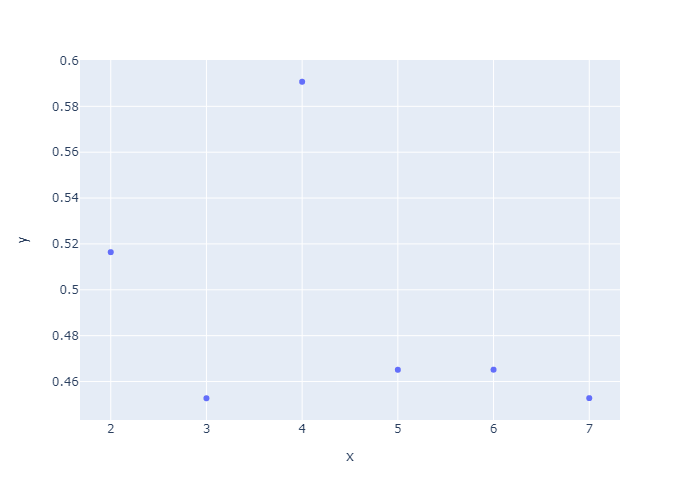

In [29]:
method_siluet(arr_2d, eps, 'kmedians')

Исходя из метода силуэтов, оптимальное количество кластеров для обоих методов 4

### Пункт 7 Реализовать алгоритм поиска сгущений при различных радиусах 𝑅, отобразить полученные кластеры, выделить каждый кластер разным цветом или маркером, отметить центроиды. Результаты представить в виде таблицы:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def display_step(X, centroids, R):
    X = np.array(X)
    print(len(X))

    centroids = np.array(centroids)
    plt.figure(figsize=(7, 7))
    axes = plt.gca()
    axes.set_xlim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1])

    if len(X) > 0:
        plt.title(f'Forel Step {len(centroids)}')
        plt.scatter(X[:, 0], X[:, 1], marker="o", color='purple')

    plt.scatter(centroids[len(centroids)-1, 0], centroids[len(centroids)-1, 1],
                c='black', s=40)
    axes.add_patch(plt.Circle((centroids[len(centroids)-1, 0], centroids[len(centroids)-1, 1]), R,  color='purple', alpha = 0.05))
    axes.set_aspect('equal', adjustable='datalim')
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


def display(X, centroids, labels, R):
    X = np.array(X)
    centroids = np.array(centroids)

    plt.figure(figsize=(7, 7))
    axes = plt.gca()
    axes.set_xlim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1])
    plt.title("FOREL")
    #print(centroids)
    count_points = np.array(np.unique(labels, return_counts=True))
    point_in_classter = pd.DataFrame({"X_center": centroids[:, 0], "Y_center": centroids[:, 1],
                                        "quantity points in cluster": count_points[1]})
    #print(point_in_classter)
    create_table(labels, centroids)
    # Оценка качества
    plt.scatter(X[:, 0], X[:, 1], c=labels,
                    s=40, cmap='Paired', marker="*")

    plt.scatter(centroids[:, 0], centroids[:, 1],
                c='black', s=60, alpha=0.3)
    for i in range(len(centroids)):  
        axes.add_patch(plt.Circle((centroids[i, 0], centroids[i, 1]), R,  color='purple', alpha = 0.05))
    axes.set_aspect('equal', adjustable='datalim')
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


def count_labels(cur_data, clusters):
    labels = np.zeros(len(cur_data))
    j = 0
    for c in clusters:
        for k in range(len(cur_data)):
            for el in c:
                if cur_data[k][0] == el[0] and cur_data[k][1] == el[1]:
                    labels[k] = j
        j += 1

    return labels


def cluster(points, radius, tol=1e-3):
    clusters = []
    centroids = []

    while len(points) != 0:
        # Выбираем слуйчаную точку для центроиды
        current_point = get_random_point(points)
        # Вычисляем попавших в радиус
        neighbors = get_neighbors(current_point, radius, points)
        # Вычисляем центроиду
        centroid = get_centroid(neighbors)
        while np.linalg.norm(current_point - centroid) > tol:
            current_point = centroid
            neighbors = get_neighbors(current_point, radius, points)
            centroid = get_centroid(neighbors)

        centroids.append(current_point)
        clusters.append(neighbors)
        #display_step(neighbors, centroids, radius) #если нужны шаги то включить 
        points = remove_points(neighbors, points)

    return centroids, clusters


def get_neighbors(p, radius, points):
    neighbors = [point for point in points if np.linalg.norm(p - point) < radius]
    return np.array(neighbors)


def get_centroid(points):
    return np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])


def get_random_point(points):
    random_index = np.random.choice(len(points), 1)[0]
    return points[random_index]

def remove_points(subset, points):
    k = 0
    index = []
    for i in range(len(points)):
        for j in range(len(subset)):
            if (points[i][0] == subset[j][0]) and points[i][1] == subset[j][1]:
                index.append(i)
    a = np.delete(points[..., 0], index)
    b = np.delete(points[..., 1], index)
    p = np.c_[a, b]
    return np.array(p)

def forel_clustering(X, R):
    centroids, clusters = cluster(X, R)
    labels = count_labels(X, clusters)
    display(X, centroids, labels, R)



In [13]:
R = np.array([0.2, 0.4, 0.7])

Алгоритм для R = 0.2

  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.02569302 0.26986515]              50
1            2.0  [0.08909545 0.07308091]              10
2            3.0  [1.         0.21058091]               1
3            4.0  [0.00409403 0.96084025]               4
4            5.0  [0.0393999  0.55624211]              23
5            6.0  [0.46476298 0.22354772]               3
∑                                                      91


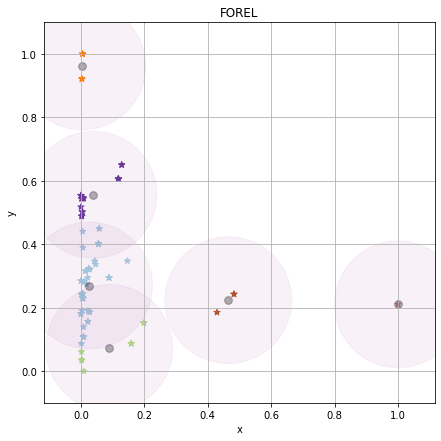

In [14]:
forel_clustering(arr_2d, R[0])


Алгоритм для R = 0.4

  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.03713016 0.32551367]              83
1            2.0  [0.00409403 0.96084025]               4
2            3.0  [0.46476298 0.22354772]               3
3            4.0  [1.         0.21058091]               1
∑                                                      91


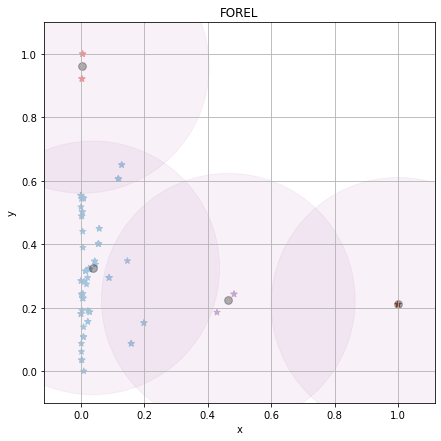

In [15]:
forel_clustering(arr_2d, R[1])


Алгоритм для R = 0.7

  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.04991632 0.35035154]              90
1            2.0  [1.         0.21058091]               1
∑                                                      91


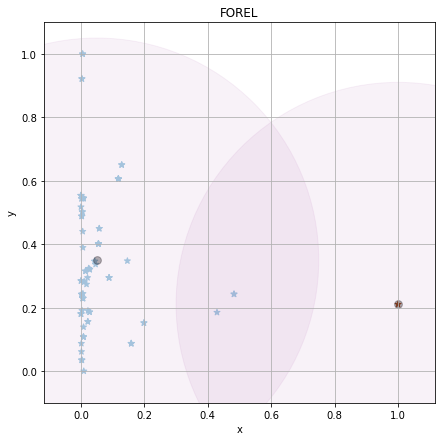

In [16]:
forel_clustering(arr_2d, R[2])


### Пункт 8 Проверить чувствительность метода поиска сгущений к погрешностям. Сделать выводы.


  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.02149294 0.35093701]              61
1            2.0  [0.06159933 0.08537344]              15
2            3.0  [0.00409403 0.96084025]               4
3            4.0  [0.12096344 0.61855365]               7
4            5.0  [0.46476298 0.22354772]               3
5            6.0  [1.         0.21058091]               1
∑                                                      91


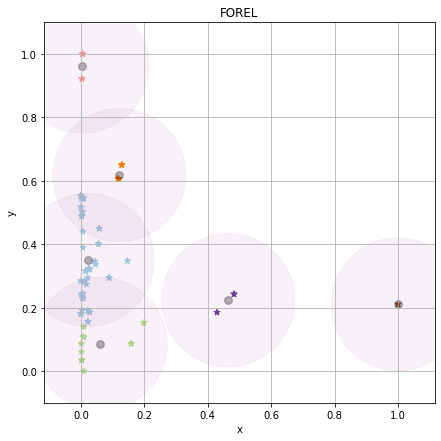

  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.03713016 0.32551367]              83
1            2.0  [0.00409403 0.96084025]               4
2            3.0  [0.46476298 0.22354772]               3
3            4.0  [1.         0.21058091]               1
∑                                                      91


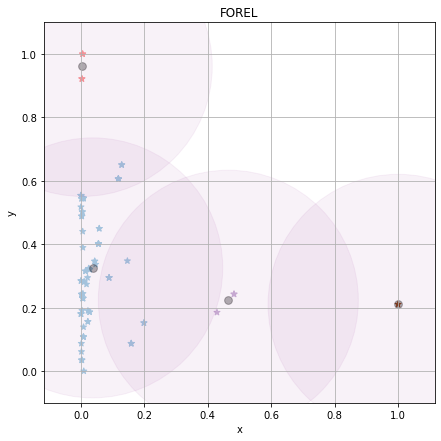

  Номер кластера        Центроид кластера  Объем кластера
0            1.0  [0.04991632 0.35035154]              90
1            2.0  [1.         0.21058091]               1
∑                                                      91


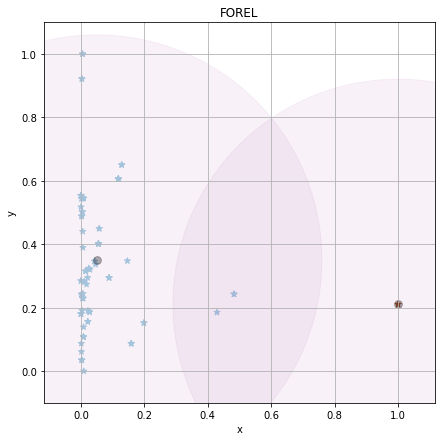

In [17]:
R += 0.01

forel_clustering(arr_2d, R[0])
forel_clustering(arr_2d, R[1])
forel_clustering(arr_2d, R[2])


#### Вывод: для проверки чувствительности метода изменяем R на некоторую  малую $\alpha$, которая будет являться погрешностью.  Можно заметить, что результаты не изменились из этого можно сделать предположить, что метод не чувтвителен к малым погрешностям

### Пункт 9 Сравнить методы. Сделать выводы.



#### Вывод: так как некоторые точки расположены очень далеко друг от друга, целесообразней использовать метод поиска сгущений.

### Пункт 10* Реализовать модификацию k-means++. Объяснить её приемущества. Сравнить с обычным методом k-means.

In [31]:
kmeans_plus_plus = my_Clustering()
kpp_clus, cpp_centr = kmeans_plus_plus.train(arr_2d, quantity_clus, eps, 'kmeans++')

kmeans++ это модифицированный kmeans, суть метода заключается в том, чтобы найти более хорошие начальные значения центроидов

kmeans
  Номер кластера        Центроид кластера  Объем кластера
0              1  [0.59857224 0.22030602]               4
1              2  [0.00949041 0.51596964]              19
2              3  [0.00409403 0.96084025]               4
3              4  [0.0436536  0.12033195]              24
4              5  [0.03051682 0.30292028]              33
5              6  [0.12096344 0.61855365]               7
∑                                                      91


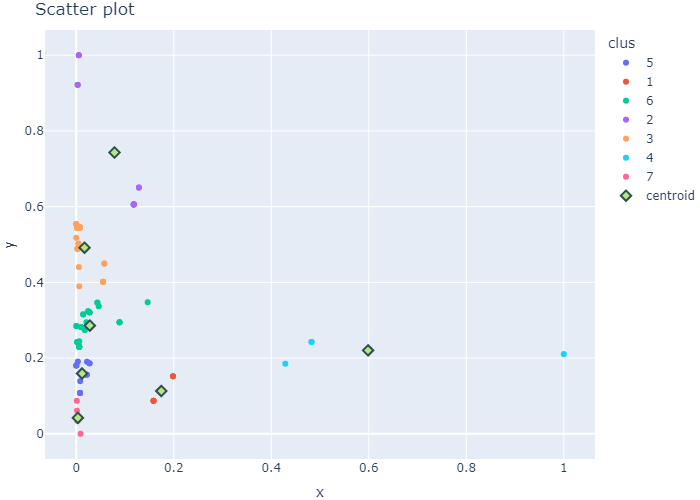

kmeans++
  Номер кластера        Центроид кластера  Объем кластера
0              1  [0.04086206 0.54771784]              25
1              2  [0.00891127 0.22320945]              23
2              3  [0.06159933 0.08537344]              15
3              4  [0.59857224 0.22030602]               4
4              5  [0.00409403 0.96084025]               4
5              6  [0.04656513 0.34551349]              20
∑                                                      91


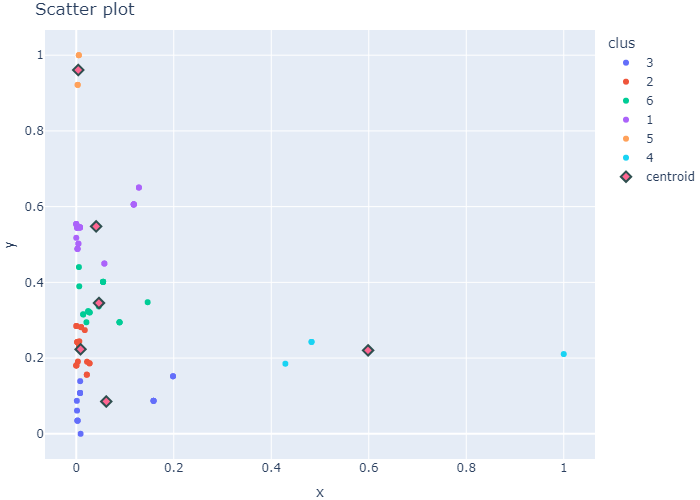

In [21]:
print('kmeans')
create_table(kmeans_clus, kmeans_centr)
kmeans.plot_clusters()

print('kmeans++')
create_table(kpp_clus, cpp_centr)
kmeans_plus_plus.plot_clusters()

По результатам можно сказать, что метод kmeans++ лучше определяет точки, которые принадлежат определенному кластеру

## Выводы

Общий вывод по проделанной работе.

Нормализовано множество точек выборки

Определена грубая верхняя оценка количества кластеров $\tilde k = 6$ 

Самостоятельно реализован и изучен алгоритм k-means, отображены кластеры полученые методом k-means

Самостоятельно реализован алгоритм k-medians

С помощью метода селуэта выявлено оптимальное количество кластеров 4

Реализован алгоритм поиска сгущений при различных радиусах R

Проверена чувствительность метода и получено, что метод не чувствителен к погрешностям

Проведено сравнение методов 

Реализована модификация метода k-means